In [217]:
import gensim
import gensim.downloader as api
import pandas as pd
import ast
import pyro 
import torch 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pyro.distributions as dist
from torch.nn import Embedding
import ast
from tqdm import tqdm
from collections import Counter 
import itertools

from pyro.contrib.autoguide import AutoDiagonalNormal, AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, JitTraceEnum_ELBO
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

import zipfile
import os


In [456]:
import warnings
warnings.simplefilter('ignore')


In [193]:
import pandas as pd 
from sklearn.manifold import TSNE
import ast
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
import json
from sklearn.linear_model import LogisticRegression

In [195]:
model = api.load('glove-wiki-gigaword-100')

In [83]:
dat = pd.read_csv('data/cleaned_documents.csv',converters = {"text":ast.literal_eval})

In [159]:
E = 100 # size of embedding


In [90]:
# words= list(itertools.chain.from_iterable(dat.text))
# words = [x for x in words if x ]
# uni_freq = Counter(words)
# words = set(words)
# word2idx = {word:idx for idx, word in enumerate(words)}
# idx2word = {idx:word for idx, word in enumerate(words)}
# W = len(set(words))

In [196]:
words= list(itertools.chain.from_iterable(dat.text))
words = [x for x in words if x in model]
uni_freq = Counter(words)
words = set(words)
word2idx = {word:idx for idx, word in enumerate(words)}
idx2word = {idx:word for idx, word in enumerate(words)}
W = len(set(words))

In [197]:
W + 292

10000

In [198]:
for each in uni_freq:
    uni_freq[each] = uni_freq[each]**0.75
deno = sum(uni_freq.values())
for each in uni_freq:
    uni_freq[each] = uni_freq[each]/deno


In [199]:
U = [model.get_vector(word) if word in model else [0]*300 for word in words]

In [200]:
# Hard coding context window size to 3.
c = 2
neg_samples = 2*c
def get_pos_neg_sample(dat):
    x_plus = []
    x_neg = []
    uni_keys = list(uni_freq.keys())
    uni_values = list(uni_freq.values())
    for each in dat.text:
        
        x_plus_n = []
        x_neg_n = []
        sentence = [x for x in each if x in words]
        random_sample = np.random.choice(uni_keys, len(sentence)*neg_samples, p = uni_values)
        r_i = 0
        for idx, token in enumerate(sentence):
            context = sentence[max(idx-c,0):min(idx+c+1, len(sentence))]
            context.remove(token)
            for every in context:
                x_plus_n.append((word2idx[token], word2idx[every]))
                
            for sample in random_sample[r_i:r_i+len(context)]:
                x_neg_n.append((word2idx[token], word2idx[sample]))
            r_i+=len(context)
            
        x_plus.append(x_plus_n)
        x_neg.append(x_neg_n)
    return x_plus, x_neg

In [201]:
x_plus, x_neg = get_pos_neg_sample(dat)

In [202]:
V=U

In [203]:

def get_loss(U,V, d_i, X_plus, X_neg):
    t1 =  -torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 1,E) ,
                                                            (V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0], E, 1))))) - torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 1, E) ,
                                                            (V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0], E, 1)))))
    t2 =  - torch.sum(torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).log_prob(U))
    t3 =  - torch.sum(torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).log_prob(V))
    t4 =  - torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).log_prob(d_i)
    
    return t1 + t2 + t3 + t4
    
    

In [205]:
# lamb = 1
# phi = 1
# annealed_rate = 0.001
# alpha = 0.9999
# n_iter = 100
# loss = []
# # U = torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample()
# V = torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample()
# # U.requires_grad=True
# V.requires_grad=True
# optimizer = torch.optim.Adam([ V], lr = 0.01)
# len_ = len(x_plus)
# for it in range(1):
#     for n in range(len_):
#         for g in optimizer.param_groups:
#             g['lr'] *= alpha
#         d_i = Variable(torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).rsample(), requires_grad=True)
#         opti = torch.optim.Adam([d_i], lr = 1)
#         X_plus = torch.tensor(x_plus[n])
#         X_neg = torch.tensor(x_neg[n])
#         #SGD for d_i
#         for iterat in range(n_iter):
#             # Loss function
#             opti.zero_grad()
#             logProb = get_loss(U,V, d_i, X_plus, X_neg)
#             logProb.backward()
#             opti.step()
#             # if iterat==0 or iterat==n_iter-1:
#             #   print("Iter : {}, logprob : {}".format(iterat, logProb))
#         optimizer.zero_grad()
#         log_loss = get_loss(U,V, d_i, X_plus, X_neg)
#         log_loss.backward()
#         optimizer.step()
#         loss.append(log_loss)
#         if n%100==0:
#             print("Iteration : {}, logProb : {}".format(n+1, logProb))


In [388]:
torch.tensor([1,2]).tolist()

[1, 2]

In [295]:
ind = []

In [459]:
def model(X_full, Y_full, U, V):
    lamb = 0.01
    phi = 0.01
    annealed_rate = 0.001
    alpha = 0.999
    n_iter = 100
    with pyro.plate('K', len(X_full)):
        d_i = pyro.sample("d_i", dist.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)))
    with pyro.plate('observations', len(X_full), 1) as idx:
        X = torch.tensor(X_full[idx])
        Y = Y_full[idx]
        logit = torch.bmm(U[X[:,0]].view(U[X[:,0]].shape[0], 1, E) ,(V[X[:,1]]+d_i[idx]).view((V[X[:,1]]+d_i[idx]).shape[0],E,1))
        target = pyro.sample('obs', dist.Bernoulli(logits=logit), obs=Y)
    return d_i



In [460]:
# def model(X_full, Y_full, U, V):
#     phi = 10
#     with pyro.plate('K', len(X_full)):
#         d_i = pyro.sample("d_i", dist.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)))
#     with pyro.plate('observations', len(X_full)) as index:
#         logits = torch.tensor([])
#         y_final = torch.tensor([])
#         y_final = list(itertools.chain.from_iterable(Y_full))
#         for idx in index:
#             X = torch.tensor(X_full[idx])
# #             Y = torch.tensor(Y_full[idx])
#             ind.append(idx)
#             logit = torch.bmm(U[X[:,0]].view(U[X[:,0]].shape[0], 1, E) ,(V[X[:,1]]+d_i[idx]).view((V[X[:,1]]+d_i[idx]).shape[0],E,1))
#             logit = logit.view(len(logit))
#             y_final = torch.cat((y_final, Y))
#             logits = torch.cat((logits, logit))
# #             print(y_final.shape, logits.shape)
#     target = pyro.sample('obs', dist.Bernoulli(probs=torch.tensor(logits)), obs=y_final)
# #     return d_i





In [461]:
guide_di = AutoDelta(model)
optim = Adam({"lr":0.1})
svi_di = SVI(model,guide_di,optim,loss=Trace_ELBO())

In [462]:
U,V= torch.tensor(U), torch.tensor(V)

In [465]:
def train_d_i(x_plus,x_neg, U, V):
    lamb = 0.01
    phi = 0.01
    annealed_rate = 0.001
    alpha = 0.999
    n_iter = 1000
    losses = []
    pyro.clear_param_store()
    X = []
    Y = []
    for idx,_ in enumerate(x_plus):
        X_plus = torch.tensor(x_plus[idx])
        X_neg = torch.tensor(x_neg[idx])
        X_n = torch.cat((X_plus,X_neg))
        Y_n = torch.tensor([float(1) for each in range(len(X_plus))] + [float(0) for each in range(len(X_neg))])
        X.append(X_n)
        Y.append(Y_n)
    for i in range(n_iter):
        loss = svi_di.step(X, Y, U, V)
        losses.append(loss)
        if i%10==0:
            print("Iteration: ", i)
    return losses
losses = train_d_i(x_plus,x_neg, U, V)

Iteration:  0
Iteration:  10
Iteration:  20
Iteration:  30
Iteration:  40
Iteration:  50
Iteration:  60
Iteration:  70
Iteration:  80
Iteration:  90
Iteration:  100
Iteration:  110
Iteration:  120
Iteration:  130
Iteration:  140
Iteration:  150
Iteration:  160
Iteration:  170
Iteration:  180
Iteration:  190
Iteration:  200
Iteration:  210
Iteration:  220
Iteration:  230
Iteration:  240
Iteration:  250
Iteration:  260
Iteration:  270
Iteration:  280
Iteration:  290
Iteration:  300
Iteration:  310
Iteration:  320
Iteration:  330
Iteration:  340
Iteration:  350
Iteration:  360
Iteration:  370
Iteration:  380
Iteration:  390
Iteration:  400
Iteration:  410
Iteration:  420
Iteration:  430
Iteration:  440
Iteration:  450
Iteration:  460
Iteration:  470
Iteration:  480
Iteration:  490
Iteration:  500
Iteration:  510
Iteration:  520
Iteration:  530
Iteration:  540
Iteration:  550
Iteration:  560
Iteration:  570
Iteration:  580
Iteration:  590
Iteration:  600
Iteration:  610
Iteration:  620
Ite

In [466]:
# def train_d_i(x_plus,x_neg, U, V):
#     n_iter = 10
#     losses = []
#     pyro.clear_param_store()
#     X = []
#     Y = []
#     for idx,_ in enumerate(x_plus):
#         X_plus = torch.tensor(x_plus[idx])
#         X_neg = torch.tensor(x_neg[idx])
#         X_n = torch.cat((X_plus,X_neg))
#         Y_n = torch.tensor([float(1) for each in range(len(X_plus))] + [float(0) for each in range(len(X_neg))])
#         X.append(X_n)
#         Y.append(Y_n)
#     for it in range(n_iter):
#         loss = 0
#         for i in range(len(X)):
# #             step = i%len(x_plus)
#             loss += svi_di.step(X, Y, U, V, i)
#         losses.append(loss/len(X_plus))
#         if it>=0:
#             print("Loss = : {} in iteration : {}".format(loss, it))
#     return losses
# losses = train_d_i(x_plus,x_neg, U, V)

In [ ]:
losses

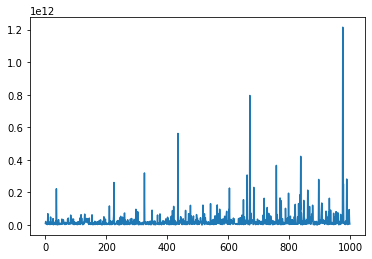

In [468]:
plt.plot(losses)

In [469]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_stats[site_name] = np.mean(marginal[:, i], axis = 0)
    return site_stats

def wrapped_model(X_full, Y_full, U, V):
    pyro.sample("prediction", dist.Delta(model(X_full, Y_full, U, V)))

X_full = x_plus
Y_full = x_neg

posterior = svi_di.run(X_full, Y_full, U, V)

# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(X_full, Y_full, U, V)
post_summary = summary(post_pred, sites= ['d_i'])
d_i = post_summary["d_i"]


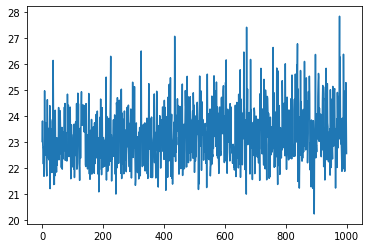

In [470]:
plt.plot(np.log(np.array(losses)))

In [471]:
def tsne_plot(emb, color_map, labels, n_comp=2):
    low_emb = TSNE(n_components=2).fit_transform(emb)
    plt.scatter(low_emb[:,0], low_emb[:,1], c = [color_map[y] for y in labels])
    plt.show()

In [472]:
labels = dat.label.values
color_map = { 'business':'red', 'entertainment':'green', 'politics':'blue', 'sport':'yellow','tech':'pink'}
en = { 'business':0, 'entertainment':1, 'politics':2, 'sport':3,'tech':4}


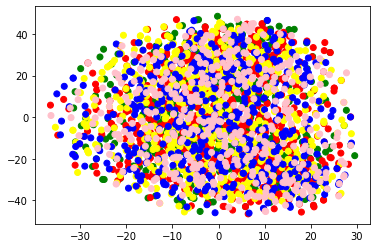

In [473]:
tsne_plot(d_i, color_map, labels)